In [1]:
'''
Loading data prepared in preprocessing.ipynb

Data collected from following sources:

OpenFEMA Dataset: FIMA NFIP Redacted Claims - Version 2
Last Data Refresh: 04-16-2024
Documentation: https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v2

EM-DAT Public Table
Documentation: https://doc.emdat.be/docs/data-structure-and-content/emdat-public-table/
Date of access: 4/29/2024

US Geological Survey National Map
Documentation: https://apps.nationalmap.gov/
Last Data Refresh: 04-26-2024
'''

import pandas as pd
import numpy as np

df = pd.read_csv("StormClaimsFlorida.csv")
df = df[df["totalAmountPaidOnClaim"] >= 0]
df.fillna(df.mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191835 entries, 0 to 191846
Data columns (total 69 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Unnamed: 0                          191835 non-null  int64  
 1   agricultureStructureIndicator       191835 non-null  int64  
 2   basementEnclosureCrawlspaceType     191835 non-null  float64
 3   policyCount                         191835 non-null  int64  
 4   crsClassificationCode               191835 non-null  float64
 5   elevatedBuildingIndicator           191835 non-null  int64  
 6   elevationCertificateIndicator       191835 non-null  float64
 7   elevationDifference                 191835 non-null  float64
 8   baseFloodElevation                  191835 non-null  float64
 9   houseWorship                        191835 non-null  int64  
 10  locationOfContents                  191835 non-null  float64
 11  lowestAdjacentGrade       

In [3]:
'''
Feature processing tools
'''

import sklearn.preprocessing as skpreprocess

# Config variable: given d, expansion beyond degree 2 infeasible
POLY_DEGREE = 2

'''
Expands feature matrix with quadratic terms
    X = the original feature matrix
    degree = the degree of polynomial expansion
'''
def polynomial_expansion(X, degree=POLY_DEGREE):
    poly_transform = skpreprocess.PolynomialFeatures(degree=degree)
    poly_transform.fit(X)
    return poly_transform.transform(X)

'''
Standardizes data and drops columns with no variance
    X = feature matrix
'''
def standardize(X):
    means = np.mean(X, axis=0)
    std_devs = np.std(X, axis=0)
    std_devs[std_devs == 0] = 1
    X_standardized = (X - means) / std_devs
    X_standardized.loc[:, std_devs == 1] = 0
    return pd.DataFrame(X_standardized)

def standardize_vector(vec):
    return (vec - np.mean(vec)) / np.std(vec)

In [4]:
'''
Labeling the dataset: Note the extreme skew in the amount of US dollars paid to
property owners (many are $0, while some payments exceed $350,000). This wide,
sparsely populated range of possible labels presents a significant challenge
to learning algorithms. To remedy this, I represent each payment as a proportion
of the total insurance which was purchased on the property.
'''

df["totalBuildingContentsCoverage"] = df["totalBuildingInsuranceCoverage"] + df["totalContentsInsuranceCoverage"]
df = df[(df["totalAmountPaidOnClaim"] > 0) & (df["totalBuildingContentsCoverage"] > 0) & (df["totalAmountPaidOnClaim"] < df["totalBuildingContentsCoverage"])]
y = df["totalAmountPaidOnClaim"]
y_proportion = np.divide(df["totalAmountPaidOnClaim"], df["totalBuildingContentsCoverage"] )
y_std_ln = standardize_vector(np.log(df["totalAmountPaidOnClaim"] + 1))
X = df.drop(["totalAmountPaidOnClaim"], axis=1)

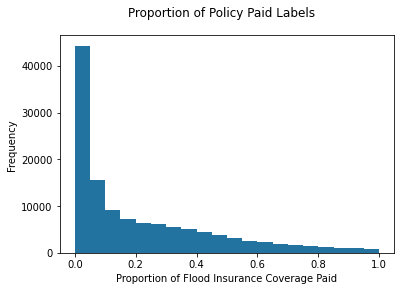

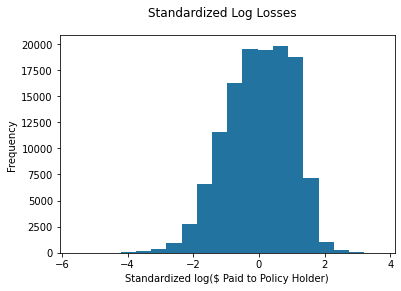

,Unnamed: 0,agricultureStructureIndicator,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,houseWorship,locationOfContents,lowestAdjacentGrade,lowestFloorElevation,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,postFIRMConstructionIndicator,smallBusinessIndicatorBuilding,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,primaryResidenceIndicator,buildingDamageAmount,buildingDeductibleCode,buildingPropertyValue,contentsDamageAmount,contentsDeductibleCode,contentsPropertyValue,disasterAssistanceCoverageRequired,ficoNumber,floodCharacteristicsIndicator,floodWaterDuration,floodproofedIndicator,iccCoverage,nfipRatedCommunityNumber,numberOfUnits,buildingReplacementCost,contentsReplacementCost,stateOwnedIndicator,waterDepth,buildingDescriptionCode,rentalPropertyIndicator,reportedZipCode,censusTract,latitude,longitude,yearsSinceConstruction,yearsSinceNBPolicy,Magnitude,USGS_Elevation,seasonOfLoss_fall,seasonOfLoss_spring,seasonOfLoss_summer,seasonOfLoss_winter,A,A01,A03,A04,A10,AE,B,C,Other,VE,X,replacementCostBasis_A,replacementCostBasis_R,totalBuildingContentsCoverage
Unnamed: 0,1.000000,-0.004649,0.028840,-0.000903,0.026252,-0.010668,-0.000726,0.003666,-0.003659,0.002630,-0.016908,-0.000496,-0.002506,-0.005314,-0.004823,-0.020042,-0.029687,-0.005815,-0.001090,-0.004583,-0.009965,-0.059696,-0.011060,-0.013766,-0.022028,0.006963,-0.005745,-0.016644,-0.004986,0.001669,-0.015236,-0.002213,-0.004789,-0.005264,-0.036356,0.000519,-0.002030,0.007401,-0.009282,0.003479,-0.007311,0.000413,-0.007562,-0.005243,0.004792,-0.009487,0.000375,0.010982,0.048900,-0.026935,-0.000117,-0.012651,0.001708,0.013426,-0.004334,0.010525,0.005306,0.001261,0.004991,0.011444,-0.025501,0.005439,0.006637,0.026352,-0.005372,-0.004214,0.009635,-0.009498,-0.004788
agricultureStructureIndicator,-0.004649,1.000000,0.002472,-0.000476,-0.000310,0.000495,0.000098,-0.001145,-0.000384,-0.000140,-0.003465,0.000008,-0.000373,-0.001735,-0.000348,0.003558,0.001593,0.000970,0.042226,-0.000693,-0.000592,0.004132,-0.006637,-0.001298,0.003935,-0.000261,0.000133,-0.001557,-0.000027,0.000580,0.002718,-0.000075,0.000002,-0.000072,0.002018,-0.001089,-0.000527,-0.000258,-0.000479,-0.000100,-0.000944,0.025086,0.007132,-0.001569,-0.000541,0.002911,0.001692,-0.001168,-0.006001,0.005552,0.000492,0.002702,-0.000230,-0.002645,-0.000393,-0.000921,-0.000261,-0.000194,-0.000235,-0.000693,-0.004312,-0.000537,-0.000580,0.001141,-0.001158,0.007463,0.004403,-0.004392,-0.000705
basementEnclosureCrawlspaceType,0.028840,0.002472,1.000000,0.018327,0.256269,0.111436,-0.012617,-0.001034,0.036791,0.010353,-0.064347,0.013563,0.034425,0.092315,-0.032112,0.127998,-0.220196,-0.025397,-0.027019,0.004622,-0.069175,-0.395136,-0.103489,-0.117551,-0.162710,0.015746,-0.022192,-0.129137,-0.019364,0.019574,-0.108769,0.006979,-0.032742,0.002479,-0.186056,-0.054994,0.008436,0.014612,-0.130295,0.004936,-0.075922,-0.008607,-0.036133,-0.106222,0.036847,0.048904,-0.047528,0.083926,0.308023,-0.169740,0.002969,-0.132051,0.012938,0.132881,-0.002073,0.027273,0.021652,0.014532,0.017729,0.056689,-0.193078,0.040421,0.043843,0.166929,0.019972,0.016377,0.026185,-0.025907,0.003171
policyCount,-0.000903,-0.000476,0.018327,1.000000,-0.000749,0.050427,0.005335,-0.009082,-0.006146,-0.002074,0.036461,0.001238,-0.005987,0.122892,0.020220,0.107735,0.031966,0.026947,-0.004103,0.903188,0.005849,0.015464,-0.094914,0.177111,0.028507,0.005238,0.001450,0.006489,0.054522,0.001623,0.009648,-0.001111,-0.001169,-0.001064,0.009229,-0.004437,0.937228,0.003792,-0.005219,-0.001486,-0.002797,0.014599,-0.012982,0.003774,-0.003862,-0.019529,0.018729,-0.019117,0.001653,0.027316,-0.006812,-0.000867,0.029056,-0.015090,0.071566,-0.013058,-0.002963,-0.002470,-0.003331,0.003607,0.001114,-0.005696,0.013404,-0.021165,0.039013,0.003262,-0.017891,0.018069,0.902613
crsClassificationCode,0.026252,-0.

In [4]:
from visualization import hist, correlation_plot

# Visualize the new labels
hist(y_proportion, title="Proportion of Policy Paid Labels", xlabel="Proportion of Flood Insurance Coverage Paid", bins=20)
hist(y_std_ln, title="Standardized Log Losses", xlabel="Standardized log($ Paid to Policy Holder)", bins=20)

# Understand linear relationships between the features
correlation_plot(X)

In [6]:
'''
Helper function to split dataset into training, validation, and testing data
'''

'''
Splits the dataset into training, validation, and testing splits
    x = the feature matrix
    y = label vector
    n_train_percent = a real number between 0 and 100
    n_val_percent = a real number between 0 and (100 - n_train_percent)
    random_state = the random seed for index splitting
'''
def split_dataset(x, y, n_train_percent, n_val_percent, random_state=1):
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(x.shape[0])

    train_split_idx = int((n_train_percent / 100) * x.shape[0])
    val_split_idx = int(((n_val_percent + n_train_percent) / 100) * x.shape[0])

    train_indices = shuffled_indices[:train_split_idx]
    val_indices = shuffled_indices[train_split_idx:val_split_idx]
    test_indices = shuffled_indices[val_split_idx:]

    x_train, y_train = x.iloc[train_indices, :], y.iloc[train_indices]
    x_val, y_val = x.iloc[val_indices, :], y.iloc[val_indices]
    x_test, y_test = x.iloc[test_indices, :], y.iloc[test_indices]

    return np.array(x_train), np.array(y_train).reshape(-1, 1), \
        np.array(x_val), np.array(y_val).reshape(-1, 1), \
        np.array(x_test), np.array(y_test).reshape(-1, 1)

In [18]:
'''
Regression Approach 1: Neural Network
I first fit a neural network to the data in order to predict insurance claims.
The network uses ReLU activation in hidden layers but sigmoid on the output
layer, because we are predicting a proportion between 0 and 1.
See neuralnet.py for network implementation.
'''

import neuralnet
import importlib
importlib.reload(neuralnet)
from neuralnet import TensorDataset, NeuralNetRegressor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim

# Split the dataset into training and testing splits
x_train, y_train, x_val, y_val, x_test, y_test = split_dataset(X, y_proportion, 80, 10, random_state=2)

# Create dataloader objects for the datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=False)
test_loader = DataLoader(test_dataset, shuffle=False)

# Instantiate the neural network
input_size = X.shape[1]
model = NeuralNetRegressor(input_size)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

'''
Execute one training epoch for the neural network
    model = instance of NeuralNetRegressor (see neuralnet.py)
    train_loader = DataLoader for training dataset
    criterion = loss function for computing gradients
    optimizer = optimization algorithm
'''
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

'''
Evaluate the model on a dataset
    model = instance of NeuralNetRegressor (see neuralnet.py)
    train_loader = DataLoader for evaluation dataset
    criterion = loss function to evaluate by
'''
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    return total_loss / len(data_loader.dataset)

'''
Query trained model for predictions on a dataset
    model = instance of NeuralNetRegressor (see neuralnet.py)
    data_loader = DataLoader for prediction dataset
'''
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs = model(inputs)
            predictions.append(outputs[0].numpy()[0])
    return predictions

# Train the network for a specified number of epochs
NUM_EPOCHS = 35
best_val_mse = float('inf')
for epoch in range(NUM_EPOCHS):
    train_mse = train_epoch(model, train_loader, criterion, optimizer)
    val_mse = evaluate_model(model, val_loader, criterion)
    
    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}: Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}')
    
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model and evaluate on test dataset
model.load_state_dict(torch.load('best_model.pth'))
test_mse = evaluate_model(model, test_loader, criterion)
print(f'Test MSE: {test_mse:.4f}')

Epoch 1: Train MSE: 0.0689, Validation MSE: 0.0689
Epoch 2: Train MSE: 0.0684, Validation MSE: 0.0685
Epoch 3: Train MSE: 0.0680, Validation MSE: 0.0680
Epoch 4: Train MSE: 0.0676, Validation MSE: 0.0676
Epoch 5: Train MSE: 0.0671, Validation MSE: 0.0672
Epoch 6: Train MSE: 0.0668, Validation MSE: 0.0668
Epoch 7: Train MSE: 0.0664, Validation MSE: 0.0664
Epoch 8: Train MSE: 0.0660, Validation MSE: 0.0660
Epoch 9: Train MSE: 0.0657, Validation MSE: 0.0657
Epoch 10: Train MSE: 0.0653, Validation MSE: 0.0654
Epoch 11: Train MSE: 0.0650, Validation MSE: 0.0650
Epoch 12: Train MSE: 0.0647, Validation MSE: 0.0647
Epoch 13: Train MSE: 0.0644, Validation MSE: 0.0644
Epoch 14: Train MSE: 0.0642, Validation MSE: 0.0642
Epoch 15: Train MSE: 0.0639, Validation MSE: 0.0639
Epoch 16: Train MSE: 0.0636, Validation MSE: 0.0636
Epoch 17: Train MSE: 0.0634, Validation MSE: 0.0634
Epoch 18: Train MSE: 0.0632, Validation MSE: 0.0631
Epoch 19: Train MSE: 0.0629, Validation MSE: 0.0629
Epoch 20: Train MSE: 

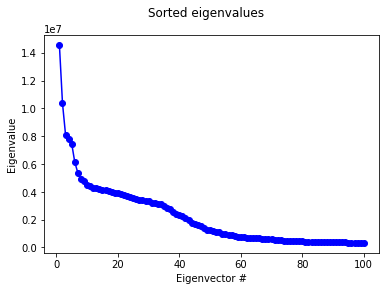

In [19]:
'''
I want to capture non-linear relationships between the data. Supporting 
polynomial feature expansion with a kernel method, however, is not feasible
because our dataset has roughly one million samples. Therefore, I perform
PCA after polynomial feature expansion and standardization.
'''

from visualization import plot
from sklearn.decomposition import PCA

# Polynomially expand the dataset and standardize
X_poly_std = standardize(pd.DataFrame(polynomial_expansion(X)))

N_COMPONENTS = 100
pca = PCA(n_components=N_COMPONENTS)
pca.fit(X_poly_std)
sorted_eigenvalues = pca.explained_variance_ * (X_poly_std.shape[0] - 1)
plot(x=range(1, N_COMPONENTS+1), y=sorted_eigenvalues, title="Sorted eigenvalues", xlabel="Eigenvector #", ylabel="Eigenvalue")

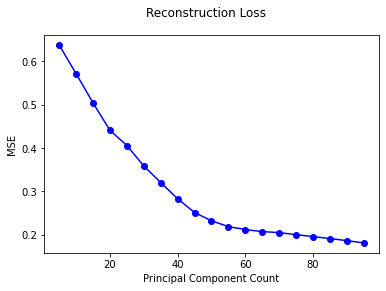

In [158]:
from sklearn.metrics import mean_squared_error

'''
Calculate reconstruction loss from PCA for the first [components] eigenvectors
    X = the feature matrix
    pca = the fitted PCA object
    k = the number of principal components to use for reconstruction
'''
def calculate_reconstruction_loss(X, pca, k):
    X_projected = pca.transform(X)
    X_projected[:, k:] = 0 
    X_reconstructed = pca.inverse_transform(X_projected)
    return mean_squared_error(X, X_reconstructed)

X_poly_std_sample = X_poly_std.sample(1000)
reconstruction_losses = []
component_set = range(5, 100, 5)
for k in component_set:
    reconstruction_losses.append(calculate_reconstruction_loss(X_poly_std_sample, pca, k))

plot(x=component_set, y=reconstruction_losses, title="Reconstruction Loss", xlabel="Principal Component Count", ylabel="MSE")

In [20]:
'''
Linear regression model on reduced dataset (after polynomial expansion)
'''

from sklearn.linear_model import LinearRegression
import sklearn.metrics as skmetrics
from sklearn.decomposition import PCA

pca = PCA(n_components=60)
pca.fit(X_poly_std)
X_poly_pca = pd.DataFrame(pca.transform(X_poly_std))
x_train, y_train, x_val, y_val, x_test, y_test = split_dataset(X_poly_pca, y_std_ln, 80, 15, random_state=1)

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

mse_train = skmetrics.mean_squared_error(lin_reg.predict(x_train), y_train)
print('Training set MSE: {:.4f}'.format(mse_train))

mse_val = skmetrics.mean_squared_error(lin_reg.predict(x_val), y_val)
print('Validation set MSE: {:.4f}'.format(mse_val))

mse_test = skmetrics.mean_squared_error(lin_reg.predict(x_test), y_test)
print('Testing set MSE: {:.4f}'.format(mse_val))

Training set MSE: 0.5618
Validation set MSE: 0.5567
Testing set MSE: 0.5567


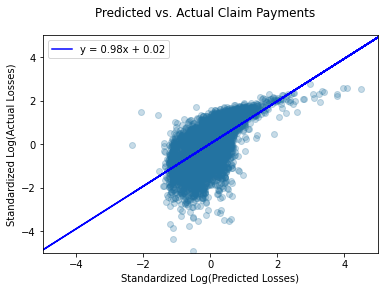

In [21]:
import visualization
importlib.reload(visualization)
from visualization import scatter

scatter(lin_reg.predict(x_test).reshape(-1), y_test.reshape(-1), "Predicted vs. Actual Claim Payments", "Standardized Log(Predicted Losses)", "Standardized Log(Actual Losses)", -5, 5, -5, 5)

In [8]:
'''
Gradient Boosting Regressor
Fits a series of decision trees to the residuals of the previous state of the
model. Decision boundaries are chosen to minimize impurity across resulting 
buckets.
'''

from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics as skmetrics

x_train, y_train, x_val, y_val, x_test, y_test = split_dataset(X, y, 25, 35, random_state=1)

gbr = GradientBoostingRegressor(n_estimators=12, min_samples_leaf=15, max_depth=3)
gbr.fit(x_train, y_train.ravel())

mse_train = skmetrics.mean_squared_error(gbr.predict(x_train), y_train)
print('Training set MSE: {:.4f}'.format(mse_train))

mse_val = skmetrics.mean_squared_error(gbr.predict(x_val), y_val)
print('Validation set MSE: {:.4f}'.format(mse_val))

mse_test = skmetrics.mean_squared_error(gbr.predict(x_test), y_test)
print('Testing set MSE: {:.4f}'.format(mse_val))

Training set MSE: 4414503474.8939
Validation set MSE: 3294951654.2190
Testing set MSE: 3294951654.2190


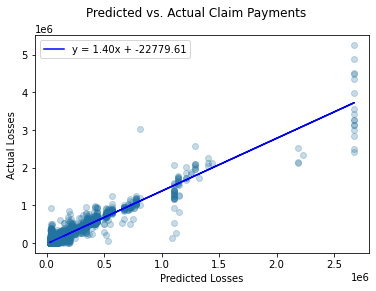

In [10]:
import visualization
import importlib
importlib.reload(visualization)
from visualization import scatter
scatter(gbr.predict(x_test).reshape(-1), y_test.reshape(-1), "Predicted vs. Actual Claim Payments", "Predicted Losses", "Actual Losses")

In [17]:
print("R2 Score:", skmetrics.r2_score(gbr.predict(x_test), y_test))
print("Correlation:", np.corrcoef(gbr.predict(x_test), y_test.reshape(-1))[0, 1])

R2 Score: 0.667301657558538
Correlation: 0.95875141858817
